## Prepare Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

def count_files(directory):
    # List all files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(files)

# Replace 'your_directory_path' with the path to the folder
directory_path = "./random_2000"
print(f"Number of files: {count_files(directory_path)}")



Number of files: 2000


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Sep 18 08:52:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [ ]:

print(torch.version.cuda)

12.1


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
%%capture

!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets transformers accelerate evaluate jiwer tensorboard gradio
!pip install --upgrade --quiet optuna
!pip install --upgrade --quiet bitsandbytes
# !pip install --upgrade --quiet huggingface_hub

In [ ]:
# connect to huggingFace

from huggingface_hub import notebook_login

notebook_login()


## Load Dataset

In [ ]:
from datasets import Dataset, Audio, DatasetDict, load_dataset
import pandas as pd

In [ ]:
# import preprocessed audio transcriptions
transcriptions_fpath = "./metadata-2000.csv"

transcriptions_df = pd.read_csv(f"{transcriptions_fpath}")

In [ ]:
transcriptions_df.head(5)

,file_name,transcription
0,_image_0011_u893_5_1683649978142_18932.mp3,Mmɔfra anan a ɔde bokiti ato nsu mu resaw. Asa...
1,_image_0021_u122_1_1679478597335_15765.mp3,Akataasiaba wɔ ne gyaadze. Okitsa biribi wɔ ne...
2,_image_0021_u192_1_1679697868381_03106.mp3,Ɔbea bi gyina kitchen a ɔkura fon wɔ ne nsam a...
3,_image_0027_u190_1_1679725603456_09436.mp3,Ɔbaa bi hyɛ ataade tuntum. Ɔtena akonnwa so. L...
4,_image_0042_u193_1_1679693018754_03110.mp3,"Papa penyin bi te egua so, na abranteɛ bi kita..."


In [ ]:
transcriptions_df.shape

(2000, 2)

In [ ]:
#load custom audio files, downsample and split them for training

audio_fpath = "./random_2000"

dataset = load_dataset("audiofolder", data_dir=f"{audio_fpath}")
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Prepare Feature Extractor, Tokenizer and Data

In [ ]:
model_ckeckpoint = "openai/whisper-small"
model_task = "transcribe"
hf_repo = "nyarkssss/dropout20-weightdecay0"


In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(f"{model_ckeckpoint}")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

### Load WhisperTokenizer

In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(f"{model_ckeckpoint}", task=f"{model_task}")

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

### Combine To Create A WhisperProcessor

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(f"{model_ckeckpoint}", task=f"{model_task}")

### Prepare Data

In [ ]:
dataset['train'][0]

{'audio': {'path': '/content/drive/MyDrive/Colab Notebooks/whispher-ak-gh-new-era/dataset/random_2000/ak_gh_image_0510_u128_1_1688772721888_00779.mp3',
  'array': array([ 0.00224687,  0.00277365,  0.00271324, ..., -0.00013292,
         -0.00020224,  0.        ]),
  'sampling_rate': 16000}}

In [ ]:
# view training dataset

print("train_dataset.shape: ", dataset["train"], '\n')
print("test_dataset.shape: ", dataset["test"])

train_dataset.shape:  Dataset({
    features: ['audio'],
    num_rows: 1600
}) 

test_dataset.shape:  Dataset({
    features: ['audio'],
    num_rows: 400
})


In [ ]:
# convert transcriptions pandas dataframe into a python dictionary :: {"file_name": "transcription"} for further processing

transcription_dict = pd.Series(transcriptions_df.transcription.values, index=transcriptions_df.file_name).to_dict()

In [ ]:
def prepare_data(dataset):

  # load audio
  audio = dataset['audio']

  # get corresponding audio transcriptions into dataset
  audio_file_name = audio["path"].split('/')[-1]
  transcription = transcription_dict.get(audio_file_name, "Transcription not found")
  # print(transcription)

  # attach transcriptions to audio
  dataset['sentence'] = transcription

  # extract log-mel spectogram features from audio array
  dataset["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

  # encode target text into label ids
  dataset['labels'] = tokenizer(transcription).input_ids
  return dataset


In [ ]:
# load and convert audios log-mel spectrum, and append corresponding transcription
dataset = dataset.map(prepare_data, remove_columns=dataset.column_names["train"])

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
# verify that the whisper tokenizer has been loaded properly
input_str = dataset["train"][0]["labels"]

# Convert list of token IDs to a string
input_str = tokenizer.decode(input_str, skip_special_tokens=True)
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 Nnipadɔm bi reyɛ campaign ama amannyɔni bi. Dodoɔ no ara wɔ truck bi mu a wɔapagyapagya wɔn nsa. Ebi nso te moto sakere so a wɔkuta amannyɔni no mfonin. 
Decoded w/ special:    <|startoftranscript|><|transcribe|><|notimestamps|>Nnipadɔm bi reyɛ campaign ama amannyɔni bi. Dodoɔ no ara wɔ truck bi mu a wɔapagyapagya wɔn nsa. Ebi nso te moto sakere so a wɔkuta amannyɔni no mfonin. <|endoftext|>
Decoded w/out special: Nnipadɔm bi reyɛ campaign ama amannyɔni bi. Dodoɔ no ara wɔ truck bi mu a wɔapagyapagya wɔn nsa. Ebi nso te moto sakere so a wɔkuta amannyɔni no mfonin. 
Are equal:             True


## Training and Evaluation

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(f"{model_ckeckpoint}")

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

In [ ]:
# model generation config

model.generation_config.suppress_tokens = []
model.generation_config.task = "transcribe"
model.generation_config.forced_decoder_ids = None

# model config
model.config.use_cache = False
model.config.dropout = 0.2
model.config.activation_dropout = 0.2



In [ ]:
from transformers import GenerationConfig
model.generation_config.save_pretrained(f"{hf_repo}", push_to_hub=True)

In [ ]:
# Push model's configuration to Hugging Face Hub

model.config.save_pretrained(f"{hf_repo}", push_to_hub=True)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


### Define a Data Collator

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

Let's initialise the data collator we've just defined:

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

### Evaluation Metrics

We'll use the word error rate (WER) metric, the 'de-facto' metric for assessing
ASR systems. For more information, refer to the WER [docs](https://huggingface.co/metrics/wer). We'll load the WER metric from 🤗 Evaluate:

In [ ]:
import evaluate

metric = evaluate.load("wer")

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    # .lower()

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Define the Training Configuration

In [ ]:
from transformers import EarlyStoppingCallback

# defining early stopping criteria
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=f"{hf_repo}",  
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  
    learning_rate=0.0001, #1e-5
    warmup_steps=200,
    warmup_ratio =0.1,
    max_steps=2000,
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=500,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
    max_grad_norm=1.0,
    save_total_limit=1,

)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
    callbacks=[early_stopping],
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs


### Training

In [ ]:

# train model
trainer.train()

# push model to hub
kwargs = {
    "dataset_tags": "speech_data_ghana_ug",
    "dataset": "Speech Data Ghana UG - Ghanaian Multilingual Sample Data",
    "language": "ak",
    "model_name": "Whisper Small Akan",
    "finetuned_from": "openai/whisper-tiny",
    "tasks": "automatic-speech-recognition",
    "tags": "akan-whisper-small",
}

trainer.push_to_hub(**kwargs)

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss,Wer
500,0.140200,0.646659,43.449335
1000,0.025600,0.809671,42.725545
1500,0.001200,0.843759,40.122825
2000,0.000200,0.862456,39.808452


You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, 50259], [2, 50359], [3, 50363]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 

CommitInfo(commit_url='https://huggingface.co/nyarkssss/dropout20-weightdecay0/commit/26d902e540f1275a608d99a2e9626efc6796687c', commit_message='End of training', commit_description='', oid='26d902e540f1275a608d99a2e9626efc6796687c', pr_url=None, pr_revision=None, pr_num=None)

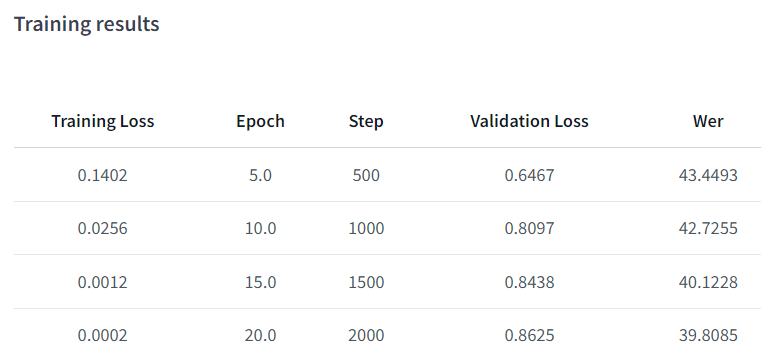